In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from tabu_search.p5 import p5_freq_tabu_search
import pandas as pd
import seaborn as sns

MAX_ITERS = 200
DPI = 100

In [2]:
s0 = np.random.randint(2, size=8)


def cost(s):
    weights = np.array([10, 14, 9, 8, 7, 5, 9, 3])
    constraints = np.array([7, 12, 8, 9, 8, 6, 11, 5])
    if np.dot(constraints, s) > 38:
        return 1
    return -np.dot(weights, s)

# Finding the exact optimum

In [3]:
all_8bit_binaries = np.array(list(product([0, 1], repeat=8)))
min_soln = min(all_8bit_binaries, key=cost)
print(min_soln, cost(min_soln))

[1 1 1 0 0 0 1 0] -42


In [4]:
np.sum(np.array([cost(s) for s in all_8bit_binaries]) == -42)

1

# Using TS

<Axes: xlabel='Iteration'>

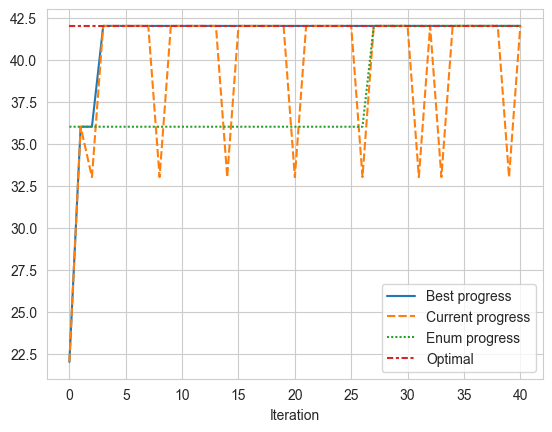

In [5]:
def form_result(results, max_iters=MAX_ITERS) -> pd.DataFrame:
    def run_enum():
        initial = list(product([0, 1], repeat=8))
        np.random.shuffle(initial)

        best_cost = cost(initial[0])
        bests = [best_cost]

        for i in range(1, max_iters + 1):
            if cost(initial[i]) < best_cost:
                best_cost = cost(initial[i])
            bests.append(best_cost)

        return bests

    dfs = [
        pd.DataFrame({
            "Iteration": np.arange(max_iters + 1),
            "Best progress": np.array(result.progress_best) * -1,
            "Current progress": np.array(result.progress_current) * -1,
            "Enum progress": np.array(run_enum()) * -1,
        }) for result in results
    ]
    combined = pd.concat(dfs).set_index("Iteration")
    combined["Optimal"] = 42
    return combined


res = p5_freq_tabu_search(s0, cost, max_iters=40)
sns.lineplot(form_result([res], 40))

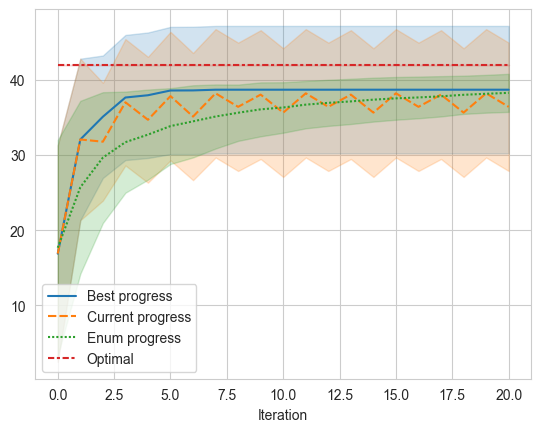

In [6]:
max_iters = 20
solns = [p5_freq_tabu_search(np.random.randint(2, size=8), cost, tenure_length=2, max_iters=max_iters)
         for _ in range(500)]
solns_df = form_result(solns, max_iters)
sns.lineplot(solns_df, errorbar='sd')
plt.savefig("../../images/p5/tenure5", dpi=DPI, bbox_inches="tight")

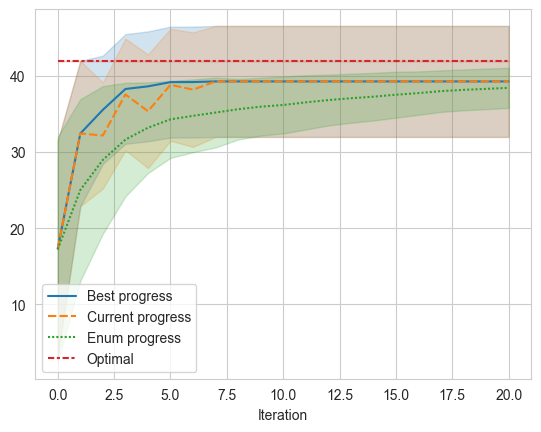

In [7]:
max_iters = 20
solns = [p5_freq_tabu_search(np.random.randint(2, size=8), cost, tenure_length=50, max_iters=max_iters)
         for _ in range(500)]
solns_df = form_result(solns, max_iters)
sns.lineplot(solns_df, errorbar='sd')
plt.savefig("../../images/p5/tenure50", dpi=DPI, bbox_inches="tight")

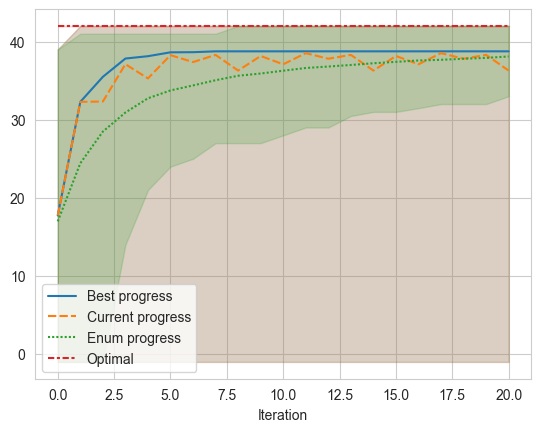

In [8]:
solns = [p5_freq_tabu_search(np.random.randint(2, size=8), cost, max_iters=max_iters)
         for _ in range(500)]
solns_df = form_result(solns, max_iters)
sns.lineplot(solns_df, errorbar='pi')
plt.savefig("../../images/p5/pi", dpi=DPI, bbox_inches="tight")

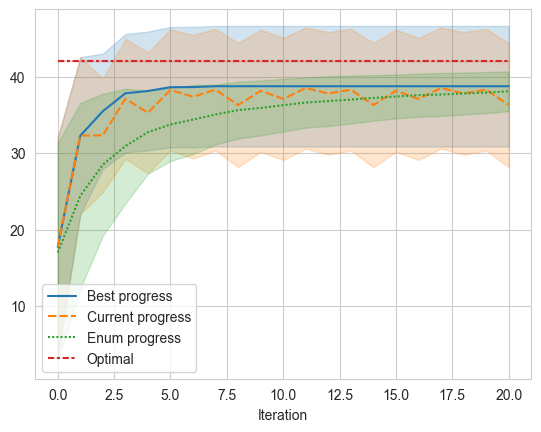

In [9]:
sns.lineplot(solns_df, errorbar='sd')
plt.savefig("../../images/p5/sd", dpi=DPI, bbox_inches="tight")

In [10]:
def sim_til_optimal():
    i = 0
    ccost = None
    while ccost is None or ccost > -42:
        i += 1
        ccost = p5_freq_tabu_search(np.random.randint(2, size=8), cost, max_iters=10, explore_interval=10).cost
    return i


sim_results = [sim_til_optimal() for _ in range(10000)]
np.mean(sim_results)

1.7747

In [28]:
from time import time_ns


def time_enumerate(n):
    start = time_ns()
    solns = []
    for _ in range(n):
        enums = list(product([0, 1], repeat=8))
        np.random.shuffle(enums)
        solns.append(cost(min(enums[:10], key=cost)))
    stop = time_ns()
    return (stop - start) / n / 1e9, solns


def time_ts(n):
    start = time_ns()
    final_costs = [
        p5_freq_tabu_search(np.random.randint(2, size=8), cost, max_iters=10).cost
        for _ in range(n)
    ]
    stop = time_ns()
    return (stop - start) / n / 1e9, final_costs

In [29]:
n = 10000
ts = time_ts(n)
en = time_enumerate(n)

en[0], ts[0]

(5.60048e-05, 0.0003143718)

In [30]:
np.mean(np.array(ts[1]) == -42)

0.5625

In [31]:
np.mean(np.array(en[1]) == -42)

0.0411

In [32]:
en[1]

[-33,
 -35,
 -26,
 -33,
 -36,
 -40,
 -31,
 -35,
 -33,
 -38,
 -36,
 -35,
 -36,
 -38,
 -37,
 -33,
 -36,
 -41,
 -40,
 -33,
 -36,
 -29,
 -35,
 -37,
 -39,
 -36,
 -35,
 -37,
 -40,
 -36,
 -32,
 -34,
 -36,
 -36,
 -29,
 -39,
 -39,
 -36,
 -33,
 -39,
 -35,
 -36,
 -30,
 -42,
 -35,
 -37,
 -41,
 -39,
 -34,
 -32,
 -31,
 -33,
 -35,
 -33,
 -35,
 -40,
 -36,
 -37,
 -33,
 -41,
 -34,
 -29,
 -33,
 -38,
 -39,
 -39,
 -36,
 -42,
 -34,
 -31,
 -32,
 -27,
 -31,
 -35,
 -34,
 -36,
 -35,
 -29,
 -37,
 -34,
 -35,
 -31,
 -34,
 -38,
 -33,
 -38,
 -42,
 -38,
 -41,
 -41,
 -31,
 -42,
 -35,
 -36,
 -34,
 -40,
 -35,
 -37,
 -33,
 -31,
 -35,
 -41,
 -39,
 -36,
 -39,
 -38,
 -37,
 -34,
 -42,
 -31,
 -35,
 -35,
 -37,
 -36,
 -31,
 -38,
 -39,
 -33,
 -34,
 -27,
 -41,
 -41,
 -40,
 -34,
 -34,
 -35,
 -32,
 -36,
 -36,
 -31,
 -36,
 -30,
 -33,
 -41,
 -34,
 -31,
 -35,
 -34,
 -32,
 -39,
 -39,
 -42,
 -39,
 -34,
 -29,
 -38,
 -38,
 -41,
 -33,
 -36,
 -35,
 -41,
 -42,
 -24,
 -40,
 -37,
 -42,
 -32,
 -42,
 -36,
 -37,
 -34,
 -37,
 -38,
 -33,
 -40,
 -41